# Introduction
After studying the [Fire Program Analysis (FPA) fire-occurrence database](https://www.fs.usda.gov/rds/archive/Product/RDS-2013-0009.4/) of wildfires from 1992 to 2015 in the United States in [Part 1](https://github.com/fredy737/data-science/blob/master/Wildfire%20Prevention%20-%20Learning%20From%20the%20Past/Part%201%20-%20Wildfire%20Prevention%20-%20Learning%20From%20the%20Past.ipynb), we have learned that California has had the greatest number of human-caused wildfires, especially Class G wildfires that have burned more than 5000 acres. One of our motivations behind exploring the database of wildfires, especially in California, was the state's recent history of devastating wildfires, including the [Mendocino Complex Fire](https://www.nytimes.com/2018/08/07/us/california-fires-mendocino.html), the [Carr Fire](https://www.washingtonpost.com/news/post-nation/wp/2018/07/29/grandma-did-everything-she-could-carr-fire-claims-3-more-victims-spreads-in-every-direction/?utm_term=.9a8208a9405a), the [October 2017 Northern California wildfires](https://www.nytimes.com/2017/10/10/us/california-fires.html), and most recently the [Woolsey Fire](https://deadline.com/2018/11/malibu-mandatory-evacuation-socal-fires-1202498934/) and the [Camp Fire](https://www.nytimes.com/2018/11/10/us/california-wildfires-paradise-malibu.html), the deadliest wildfire in California history. 

In California, we saw that the wildfires that have burned the largest number of acres occurred from the months July to October. The summer to autumn may be considered to be the fire season for the state. We wonder if the devastation of the wildfires is connected to not only the location (i.e. is the location vulnerable to large wildfires), but also the climate. Unfortunately, the FPA database did not contain information about the temperatures, so we chose to study the temperature in California by studying the [Berkeley Earth dataset](http://berkeleyearth.org/data/).

In our analysis of the monthly average temperature time series in California in [Part 2](https://github.com/fredy737/data-science/blob/master/Wildfire%20Prevention%20-%20Learning%20From%20the%20Past/Part%202%20-%20A%20Look%20into%20Changes%20in%20Temperatures%20in%20California.ipynb), we noted that there was an increase in temperatures (especially the low and average), and these values may continue to increase in the next few years. Will the increasing temperatures come together with more destructive wildfires? We wish to expand this analysis on the entirety of the United States.

# Wildfires and Temperatures - Combining Two Datasets
## Wildfire Database
The original wildfire database did not contain any information about the temperatures reported when the wildfires were discovered (and contained). We believe the temperature values may be relevant, especially if a wildfire ends up growing to uncontrollable sizes. Our intent is to combine the FPA database with the Berkeley Earth dataset.

Let's begin by revisiting the FPA database. We will use functions defined in sqlite_helpers to make SQL queries through Python.

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import sqlite_helpers
import datetime
style.use('fivethirtyeight')

# Define colors for figures
color_map = [[55/255,126/255,184/255], [1,127/255,0], [77/255,175/255,74/255], [247/255,129/255,191/255],
             [166/255,86/255,40/255], [152/255,78/255,163/255], [153/255,153/255,153/255],
             [228/255,26/255,28/255], [55/255,126/255,184/255], [1,127/255,0]]

# Show figures inline, show all DataFrame columns
%matplotlib inline
pd.set_option('display.max_columns', 100)

database = 'FPA_FOD_20170508.sqlite'

sqlite_helpers.run_query(database, '''SELECT * FROM Fires LIMIT 1''')

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33,1730,0.1,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...


Let us now load the wildfires reported in the United States from 1992 to 2015 from the database into a DataFrame. We will focus on wildfires in the size class G, meaning we will be looking at wildfires that have burned at least 5000 acres, sometimes up to greater orders of magnitude. We will also only look at human-caused wildfires, so we will exclude fires where the causes are listed under "Lightning" (natural), "Miscellaneous" (may include fires sparked from natural causes), and "Missing/Undefined" (we'd rather know the fires are human-caused).

In [2]:
# Query the wildfires database, obtaining only the fires in California
query = '''
SELECT * FROM Fires
WHERE 
    FIRE_SIZE_CLASS = 'G'
    AND NOT STAT_CAUSE_DESCR = 'Missing/Undefined'
'''

fires = sqlite_helpers.run_query(database, query)

print('Shape of the DataFrame:')
print(fires.shape)

fires.head()


Shape of the DataFrame:
(3520, 39)


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,17,17,FS-1418878,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,109,23,,POWER,CA-ENF-017646,POWER,CA3850212028020041006,POWER,None,2004,2453284.5,280,1415,2.0,Equipment Use,2453299.5,295.0,1000,16823.0,G,38.523333,-120.211667,5.0,USFS,CA,5,005,Amador,b'\x00\x01\xad\x10\x00\x00dS\\\xf2\x8b\r^\xc0\...
1,18,18,FS-1418881,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,111,35,BHA3,FREDS,CA-ENF-18044,FREDS,CA3878712031820041013,FREDS,None,2004,2453291.5,287,1618,2.0,Equipment Use,2453295.5,291.0,1800,7700.0,G,38.780000,-120.260000,5.0,USFS,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00p=\n\xd7\xa3\x10^\xc...
2,189,192,FS-1419313,FED,FS-FIRESTAT,FS,USAZTNF,Tonto National Forest,0312,Tonto National Forest,62,4,BVR2,THREE,AZ-TNF-105,THREE FIRE COMPLEX,AZ3372311127120050621,THREE FIRE COMPLEX (THREE),THREE FIRE COMPLEX,2005,2453542.5,172,1400,1.0,Lightning,2453550.5,180.0,1800,16100.0,G,33.723333,-111.275000,5.0,USFS,AZ,7,007,Gila,b'\x00\x01\xad\x10\x00\x00\x98\x99\x99\x99\x99...
3,1506,1520,FS-1422195,FED,FS-FIRESTAT,FS,USNMGNF,Gila National Forest,0306,Gila National Forest,21,05,BS5G,FORK,NM-GNF-021,Fork WFU,NM3364710851120050529,FORK WFU,NORTH GILA COMPLEX,2005,2453519.5,149,1505,1.0,Lightning,2453611.5,241.0,1159,11936.0,G,33.613333,-108.558889,5.0,USFS,NM,3,003,Catron,b'\x00\x01\xad\x10\x00\x00t)\xe8\xd5\xc4#[\xc0...
4,1589,1603,FS-1422367,FED,FS-FIRESTAT,FS,USCOPSF,Pike and San Isabel National Forest,0212,Pike San Isabel National Forest,51,004,BY23,MASON,CO-PSF-000683,MASON,CO3816010503620050706,MASON,None,2005,2453558.5,188,0600,1.0,Lightning,2453567.5,197.0,2000,11357.0,G,38.169722,-105.038056,5.0,USFS,CO,None,None,None,"b""\x00\x01\xad\x10\x00\x00`h\x96\x80oBZ\xc0\x0..."


This DataFrame of human-caused wildfires currently has 39 features. Our objective is to make predictions about wildfire sizes to get a sense for which areas in the United States are vulnerable. We can trim this number down by removing redundant or unnecessary features. The features we will remove include:

- Identification columns (like OBJECTID, FOD_ID, FIRE_NAME, or COMPLEX_NAME)
- Columns related to fire reporting
- DIRECTORY_DOY and CONT_DOY: Redundant information provided from DISCOVERY_DATE and CONT_DATE
- STAT_CAUSE_CODE and OWNER_CODE: Redundant information provided from STAT_CAUSE_DESCR and OWNER_DESCR
- COUNTY and FIPS_CODE: Redundant information provided from FIPS_NAME

We may continue removing some of the remaining columns, but for now, we will reduce the number of columns from 39 to 12. These columns provide information regarding patterns in wildfires, such as location, causes, time of year, time of day, and types of land in which these fires occur.

In [3]:
columns = ['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_TIME', 'STAT_CAUSE_DESCR',
           'CONT_DATE', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE',
           'OWNER_DESCR', 'FIPS_NAME']

fires = fires[columns]

fires.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,FIPS_NAME
0,2004,2453284.5,1415,Equipment Use,2453299.5,1000,16823.0,G,38.523333,-120.211667,USFS,Amador
1,2004,2453291.5,1618,Equipment Use,2453295.5,1800,7700.0,G,38.780000,-120.260000,USFS,El Dorado
2,2005,2453542.5,1400,Lightning,2453550.5,1800,16100.0,G,33.723333,-111.275000,USFS,Gila
3,2005,2453519.5,1505,Lightning,2453611.5,1159,11936.0,G,33.613333,-108.558889,USFS,Catron
4,2005,2453558.5,0600,Lightning,2453567.5,2000,11357.0,G,38.169722,-105.038056,USFS,None


As we have done in Part 1, let's convert the DISCOVERY_DATE and CONT_DATE columns into datetime columns. We will also convert the DISCOVERY_TIME and CONT_TIME columns into datetime columns.

In [4]:
epoch = pd.to_datetime(0, unit='s').to_julian_date()    # Reference for Julian time
fires.loc[:, 'DISCOVERY_DATE'] = pd.to_datetime(fires['DISCOVERY_DATE'] - epoch, unit='D', errors = 'coerce')
fires.loc[:, 'CONT_DATE'] = pd.to_datetime(fires['CONT_DATE'] - epoch, unit = 'D', errors = 'coerce')

fires.loc[:, 'DISCOVERY_TIME'] = pd.to_datetime(fires['DISCOVERY_TIME'], format = "%H%M", errors = 'coerce').dt.time
fires.loc[:, 'CONT_TIME'] = pd.to_datetime(fires['CONT_TIME'], format = "%H%M", errors = 'coerce').dt.time

fires.head(10)

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,FIPS_NAME
0,2004,2004-10-06,14:15:00,Equipment Use,2004-10-21,10:00:00,16823.0,G,38.523333,-120.211667,USFS,Amador
1,2004,2004-10-13,16:18:00,Equipment Use,2004-10-17,18:00:00,7700.0,G,38.780000,-120.260000,USFS,El Dorado
2,2005,2005-06-21,14:00:00,Lightning,2005-06-29,18:00:00,16100.0,G,33.723333,-111.275000,USFS,Gila
3,2005,2005-05-29,15:05:00,Lightning,2005-08-29,11:59:00,11936.0,G,33.613333,-108.558889,USFS,Catron
4,2005,2005-07-07,06:00:00,Lightning,2005-07-16,20:00:00,11357.0,G,38.169722,-105.038056,USFS,None
5,2005,2005-08-10,16:00:00,Lightning,2005-09-30,15:00:00,7404.0,G,45.923333,-115.025000,USFS,Idaho
6,2005,2005-07-20,23:39:00,Lightning,2005-07-22,23:00:00,7892.0,G,37.173889,-113.538333,MISSING/NOT SPECIFIED,Washington
7,2005,2005-08-01,19:00:00,Lightning,2005-10-31,09:00:00,7244.4,G,45.730278,-114.706667,USFS,Idaho
8,2005,2005-08-05,15:20:00,Miscellaneous,2005-10-01,08:00:00,52000.0,G,46.234444,-117.680556,STATE OR PRIVATE,Columbia
9,2005,2005-08-26,10:43:00,Lightning,2005-10-31,10:59:00,20400.0,G,45.090556,-114.703611,USFS,Lemhi


We will keep the date and time columns for now, even though we do not expect these columns to have direct relationships with the wildfire sizes (which will be our target column). As we have previously stated, we are interested in introducing the reported average temperature when the fires were discovered, as the climate may have a significant effect.

## Temperature Dataset

We previously looked at a monthly time series of aggregate temperature values for the entire state of California. However, California is a large state with a variety in ecosystems and climates. Northern California is different from southern California, much like how coastal California is different from inland California, much like how the deserts in California are different from the Sierra Nevadas. By extension, looking at monthly time series of individual states only provides us with aggregate values.

We are instead going to look at gridded daily temperature data from Berkeley Earth. We have obtained files that report temperatures on a $1^\mathrm{o}$ x $1^\mathrm{o}$ latitude-longitude grid for every day from the start of 1990 to mid 2018. This will be convenient for our analysis as the wildfires are reported on specific days from 1992 to 2015, and their locations are reported in terms of latitude and longitude coordinates (Berkeley Earth primarily reported temperatures on equal-area grid cells different from the latitude-longitude grid).

The files that report the temperature grids are three NC files, one for each decade. NC files can be read through Python with the [netCDF4](http://unidata.github.io/netcdf4-python/) module, which requires the [netCDF-4 C library](https://github.com/Unidata/netcdf-c/releases) installed on your computer, as the Python module interfaces with this C library. A majority of the work of reading the NC files and converting the temperature grids into a single Python dictionary is performed in [temperature_us_grid.py](https://github.com/fredy737/data-science/blob/master/Wildfire%20Prevention%20-%20Learning%20From%20the%20Past/temperature_us_grid.py). For this project, we are looking at a subgrid of coordinates that contain most of the United States.

This program ultimately saves the dictionary in a pickle file, which we will now read in this project. The pickle file, "temperature_grid.pickle", can be downloaded [here](https://www.dropbox.com/s/d9r60u7wz0mq00b/temperature_us_grid.pickle.zip?dl=0).

In [5]:
import pickle

with open('temperature_us_grid.pickle', 'rb') as handle:
    temp_grid = pickle.load(handle)

We will define a function that will read the coordinates and discovery date of each wildfire, and output the average temperature at that location on that date. The coordinates will be rounded to the nearest 0.5 (but not 0.0), as that is how the latitudes and longitudes were recorded in the Berkeley Earth dataset.

In [6]:
# Define a function that returns a temperature from the temperature dictionary, given the coordinates and date
def add_temperature(row):
    # Key of the dictionary is (year, month, day)
    key_date = (row['DISCOVERY_DATE'].year, row['DISCOVERY_DATE'].month, row['DISCOVERY_DATE'].day)
    
    # Latitude and longitudes from the Berkeley Earth dataset are in 1 degree x 1 degree squares, values at 0.5
    latitude = np.floor(row['LATITUDE']) + .5
    longitude = np.floor(row['LONGITUDE']) + .5
    
    # Obtain the temperature
    temperature = temp_grid[key_date][(latitude, longitude)]
    
    return temperature

It is now time to combine the two datasets by adding a temperature column to the fires DataFrame.

In [7]:
fires['TEMPERATURE'] = fires.apply(add_temperature, axis = 1)
fires.head(15)

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,FIPS_NAME,TEMPERATURE
0,2004,2004-10-06,14:15:00,Equipment Use,2004-10-21,10:00:00,16823.0,G,38.523333,-120.211667,USFS,Amador,17.886902
1,2004,2004-10-13,16:18:00,Equipment Use,2004-10-17,18:00:00,7700.0,G,38.780000,-120.260000,USFS,El Dorado,19.159416
2,2005,2005-06-21,14:00:00,Lightning,2005-06-29,18:00:00,16100.0,G,33.723333,-111.275000,USFS,Gila,32.415512
3,2005,2005-05-29,15:05:00,Lightning,2005-08-29,11:59:00,11936.0,G,33.613333,-108.558889,USFS,Catron,16.295137
4,2005,2005-07-07,06:00:00,Lightning,2005-07-16,20:00:00,11357.0,G,38.169722,-105.038056,USFS,None,17.888496
5,2005,2005-08-10,16:00:00,Lightning,2005-09-30,15:00:00,7404.0,G,45.923333,-115.025000,USFS,Idaho,19.100348
6,2005,2005-07-20,23:39:00,Lightning,2005-07-22,23:00:00,7892.0,G,37.173889,-113.538333,MISSING/NOT SPECIFIED,Washington,27.923155
7,2005,2005-08-01,19:00:00,Lightning,2005-10-31,09:00:00,7244.4,G,45.730278,-114.706667,USFS,Idaho,18.612780
8,2005,2005-08-05,15:20:00,Miscellaneous,2005-10-01,08:00:00,52000.0,G,46.234444,-117.680556,STATE OR PRIVATE,Columbia,24.834314
9,2005,2005-08-26,10:43:00,Lightning,2005-10-31,10:59:00,20400.0,G,45.090556,-114.703611,USFS,Lemhi,13.913816


We should specify to the reader that the temperatures reported in the Berkeley Earth dataset are in the degrees of Celsius. If the reader is adamant about using Fahrenheit, they can perform the following conversion:

$T_{Fahrenheit} = (T_{Celsius} \times 9/5) + 32$

# Further Feature Preparation
Let us say we wish to use machine learning algorithms to make predictions. After all, we have now added the temperature variable to our dataset. Without addressing whether or not we can even make predictions with trained machine learning models with our current dataset, we would want to further select or engineer the features. We also need to address missing values. Let us look at missing values first.

In [8]:
fires.isnull().sum().sort_values(ascending = False)

FIPS_NAME           1718
CONT_TIME            465
CONT_DATE            417
DISCOVERY_TIME       354
TEMPERATURE            0
OWNER_DESCR            0
LONGITUDE              0
LATITUDE               0
FIRE_SIZE_CLASS        0
FIRE_SIZE              0
STAT_CAUSE_DESCR       0
DISCOVERY_DATE         0
FIRE_YEAR              0
dtype: int64

We had hoped to combine the date and time columns to introduce a new variable that reports the length of time from when a fire was discovered to when it was contained. However, the CONT_TIME, CONT_DATE, and DISCOVERY_TIME columns contain many missing values. If we were to drop the data points with missing values for CONT_TIME, CONT_DATE, and DISCOVERY_TIME, we'd be dropping roughly 350 to almost 1700 data points, or roughly 10% to half of the dataset. It will be best, instead, to remove these columns, considering the difficulty of imputation. 

We would likely not use FIPS_NAME for machine learning. The purpose of the column was to tell us the counties in which the fires have occurred, but we can also infer this information from the LATITUDE and LONGITUDE columns.

We have two other categorical columns: STAT_CAUSE_DESCR (cause of fire) and OWNER_DESCR (owner or entity responsible for managing the land at the point of origin of the fire at the time of the incident). Let us examine the values for these categories in our dataset.

In [10]:
fires['STAT_CAUSE_DESCR'].unique()

array(['Equipment Use', 'Lightning', 'Miscellaneous', 'Debris Burning',
       'Smoking', 'Campfire', 'Arson', 'Children', 'Railroad',
       'Powerline', 'Structure', 'Fireworks'], dtype=object)

Let us examine whether or not there is a relationship between these causes of wildfires and the wildfire sizes.

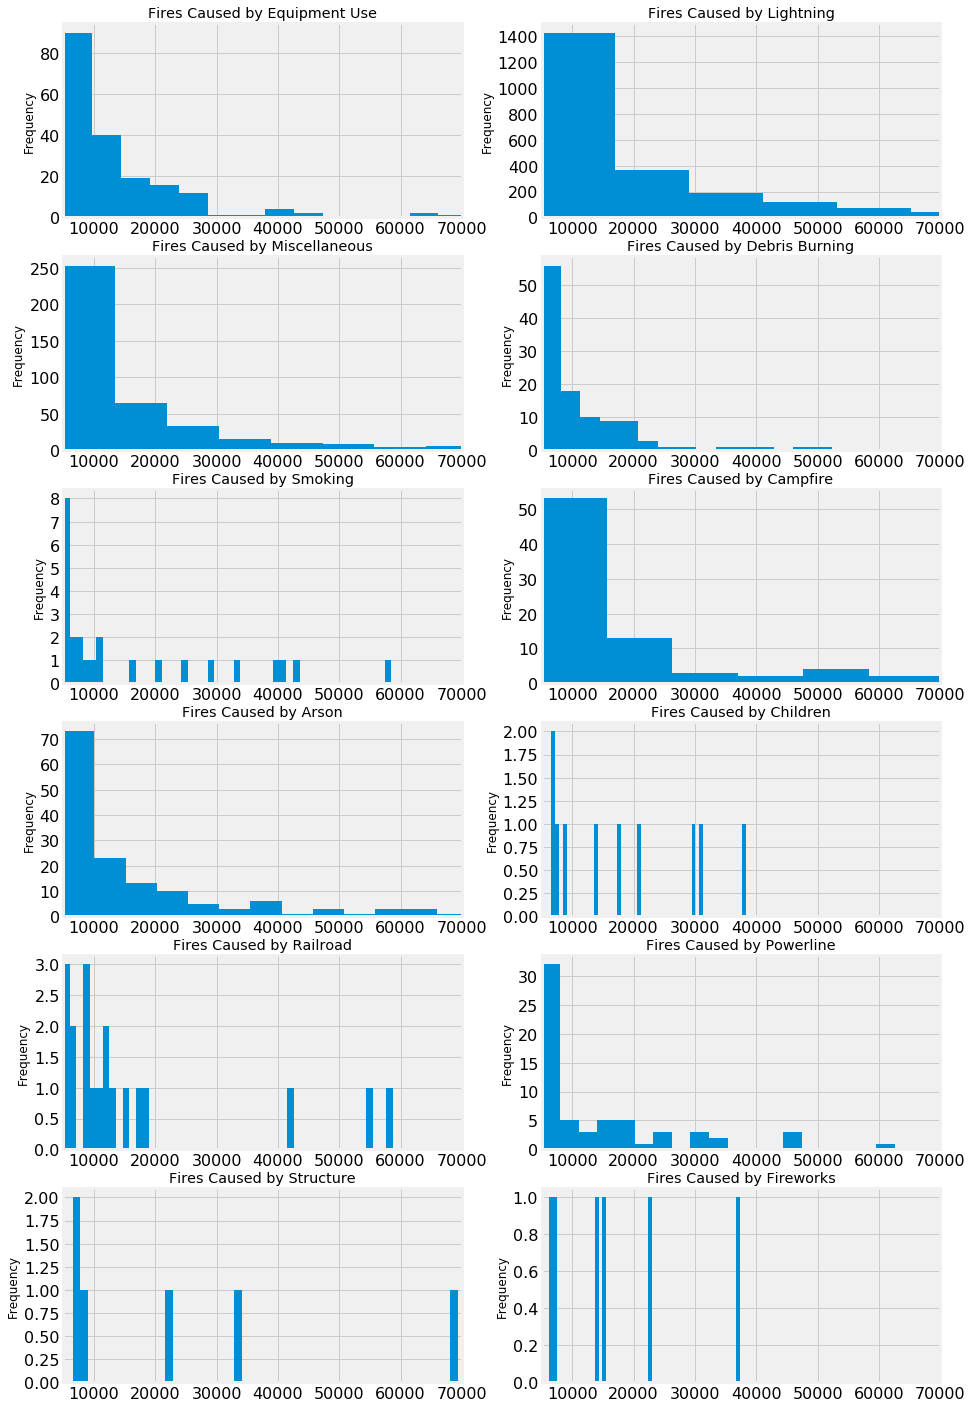

In [12]:
cause_of_fire = fires['STAT_CAUSE_DESCR'].unique()

fig = plt.figure(figsize = (14, 25))
ax = [fig.add_subplot(6,2,i+1) for i in range(12)]

for i in range(12):
    fire_size_by_cause = fires.loc[fires['STAT_CAUSE_DESCR'] == cause_of_fire[i], 'FIRE_SIZE']
    
    fire_size_by_cause.plot.hist(bins = 50, ax = ax[i], title = 'Fires Caused by ' + cause_of_fire[i], fontsize = 16)
    ax[i].set_xlim([5000, 70000])

What we observe is that there may be *some* dependence between the cause of wildfire and the resulting size. We wish to keep the STAT_CAUSE_DESCR feature, but we will need to convert the column into dummy columns.

Let us examine the OWNER_DESCR column.

In [13]:
fires['OWNER_DESCR'].unique()

array(['USFS', 'MISSING/NOT SPECIFIED', 'STATE OR PRIVATE',
       'OTHER FEDERAL', 'BIA', 'STATE', 'FWS', 'BLM', 'NPS', 'TRIBAL',
       'PRIVATE', 'COUNTY', 'BOR', 'UNDEFINED FEDERAL', 'MUNICIPAL/LOCAL'],
      dtype=object)

Initially, we kept this column in case this provided information about the land that got burned by wildfires. But this information just tells us ownership, information that may not be related to fire sizes. If we had wanted to make dummy columns from this categorical features, we would have ended up with 15 additional dummy columns, which would have significantly increased the number of features in our dataset.

What should we keep, then? We're keeping "LATITUDE" and "LONGITUDE", as we wish to see what locations are vulnerable to large wildfires. We are also keeping the "TEMPERATURE" column, as the climate may have an effect on the wildfires sizes. As we have stated beforehand, we are keeping "STAT_CAUSE_DESCR".

We are removing the following columns:
- OWNER_DESCR
- Date and time columns with too many missing values
- DISCOVERY_DATE: This column is effectively replaced by the TEMPERATURE column, which contains numerical values that are more likely to have a relationship with the target variable, FIRE_SIZE. The date by itself may not be a useful variable for predicting wildfire sizes.
- FIRE_SIZE_CLASS: Redundant. Determined by FIRE_SIZE, our target.
- FIRE_YEAR: Same reason for DISCOVERY_DATE

In [14]:
columns = ['LATITUDE', 'LONGITUDE', 'TEMPERATURE', 'STAT_CAUSE_DESCR', 'FIRE_SIZE']
fires_cleaned = fires[columns]

fires_cleaned.head()

,LATITUDE,LONGITUDE,TEMPERATURE,STAT_CAUSE_DESCR,FIRE_SIZE
0,38.523333,-120.211667,17.886902,Equipment Use,16823.0
1,38.780000,-120.260000,19.159416,Equipment Use,7700.0
2,33.723333,-111.275000,32.415512,Lightning,16100.0
3,33.613333,-108.558889,16.295137,Lightning,11936.0
4,38.169722,-105.038056,17.888496,Lightning,11357.0


Let us now convert the STAT_CAUSE_DESCR column into dummy columns with one-hot encoding. After doing so, we'll confirm that we have numerical columns with no missing values.

In [15]:
dummy_df = pd.get_dummies(fires_cleaned['STAT_CAUSE_DESCR'])

# Combine the dummy columns into the fires_cleaned DataFrame. Remove the original STAT_CAUSE_DESCR column
fires_cleaned = pd.concat([fires_cleaned, dummy_df], axis = 1)
fires_cleaned.drop(columns = ['STAT_CAUSE_DESCR'], inplace = True)

print('Types of the columns:')
print(fires_cleaned.dtypes.value_counts())

print('Number of missing values in each column:')
print(fires_cleaned.isnull().sum().sort_values())
fires_cleaned.head()

Types of the columns:
uint8      12
float64     4
dtype: int64
Number of missing values in each column:
LATITUDE          0
LONGITUDE         0
TEMPERATURE       0
FIRE_SIZE         0
Arson             0
Campfire          0
Children          0
Debris Burning    0
Equipment Use     0
Fireworks         0
Lightning         0
Miscellaneous     0
Powerline         0
Railroad          0
Smoking           0
Structure         0
dtype: int64


,LATITUDE,LONGITUDE,TEMPERATURE,FIRE_SIZE,Arson,Campfire,Children,Debris Burning,Equipment Use,Fireworks,Lightning,Miscellaneous,Powerline,Railroad,Smoking,Structure
0,38.523333,-120.211667,17.886902,16823.0,0,0,0,0,1,0,0,0,0,0,0,0
1,38.780000,-120.260000,19.159416,7700.0,0,0,0,0,1,0,0,0,0,0,0,0
2,33.723333,-111.275000,32.415512,16100.0,0,0,0,0,0,0,1,0,0,0,0,0
3,33.613333,-108.558889,16.295137,11936.0,0,0,0,0,0,0,1,0,0,0,0,0
4,38.169722,-105.038056,17.888496,11357.0,0,0,0,0,0,0,1,0,0,0,0,0


If we wish to use our current dataset, this would be the DataFrame we would attempt to use to train machine learning models. The models would make predictions about fire sizes. 

We went through so much trouble to combine our wildfire database with temperatures obtained from a gridded daily dataset, a plethora of data. We did so because we believe there may be some relationship between the temeprature and wildfire size. Let us plot these variables to see.

Text(-27,660000,'Wildfire Devastation Versus \nTemperature')

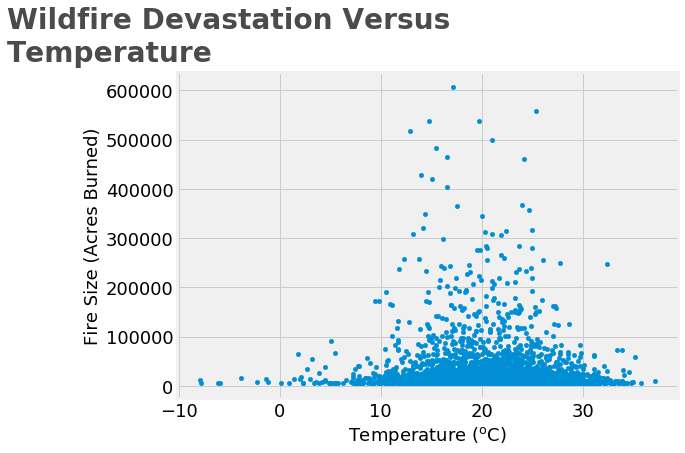

In [16]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

fires_cleaned.plot.scatter(x = 'TEMPERATURE', y = 'FIRE_SIZE', ax = ax, fontsize = 18)
ax.set_xlabel('Temperature ($^\mathrm{o}$C)', fontsize = 18)
ax.set_ylabel('Fire Size (Acres Burned)', fontsize = 18)

ax.text(-27, 660000, 'Wildfire Devastation Versus \nTemperature', fontsize = 28, alpha = .7, weight = 'bold')

The number of acres burned by Class G wildfires is close to the minimum, 5000 acres, below the freezing point (0$^\mathrm{o}$C). Some of the most devastating wildfires in this dataset occurred when the temperature ranged from roughly 12 to 25$^\mathrm{o}$C. 

The relationship between the wildfire size and the temperature can be described as nonlinear, considering the apparent decrease in the fire size beyond 30$^\mathrm{o}$C. Temperature is not the only factor contributing to wildfire devastation. A machine learning model that is made to predict the number of acres burned by fires must be multivariate, or have more than one independent variable.

At this point, we wonder if we can introduce another variable from another dataset, much like what we have done with adding temperature. A candidate for this additional variable could be humidity, as fires spread more rapidly in dry climates.